In [1]:
from mpytools import Catalog
import utils
import glob
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

target_4m_lrg = Catalog.read('/pscratch/sd/a/arocher/4MOST/target_lrg_4most_v2.fits')
target_4m_bg = Catalog.read('/pscratch/sd/a/arocher/4MOST/target_bg_mag_r19_4most_v2.fits')
mask_pixmap = Catalog.read('/pscratch/sd/e/edmondc/antoine/Legacy_Imaging_DR10_footprint_128.fits')
features_pixmap = Catalog.read('/pscratch/sd/e/edmondc/antoine/pixweight-dr10-128-new.fits')




In [32]:
nside=128 
tracer='BG'
targets = utils.create_hp_map(target_4m_lrg['RA'], target_4m_lrg['DEC'], nside=nside, nest=True)

w = utils.get_wmap(targets, features_pixmap, mask_pixmap, tracer=tracer, regions='DES')

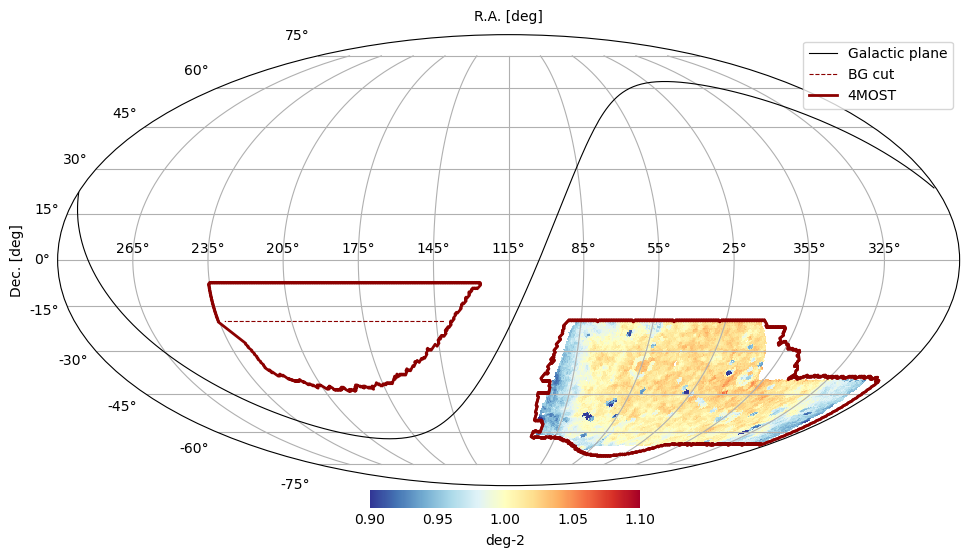

In [33]:
utils.plot_moll(w, rot=115, min=0.9, max=1.1, desi_footprint=False, fourmost_footprint=True, label='deg-2', nest=True)

In [34]:
w[w!=0].mean()

1.0003848360295753

STARDENS ::  Nb hp for the x-bin ( 2.523244086531738 <x< 2.5586225965440366 ):  563  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.5586225965440366 <x< 2.594001106556335 ):  992  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.594001106556335 <x< 2.6293796165686336 ):  1296  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.6293796165686336 <x< 2.664758126580932 ):  1269  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.664758126580932 <x< 2.7001366365932307 ):  1454  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.7001366365932307 <x< 2.7355151466055294 ):  1286  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.7355151466055294 <x< 2.7708936566178277 ):  1117  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.7708936566178277 <x< 2.8062721666301265 ):  1203  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.8062721666301265 <x< 2.8416506766424248 ):  1058  ( nb hp min= 100 ) 
STARDENS ::  Nb hp for the x-bin ( 2.8416506

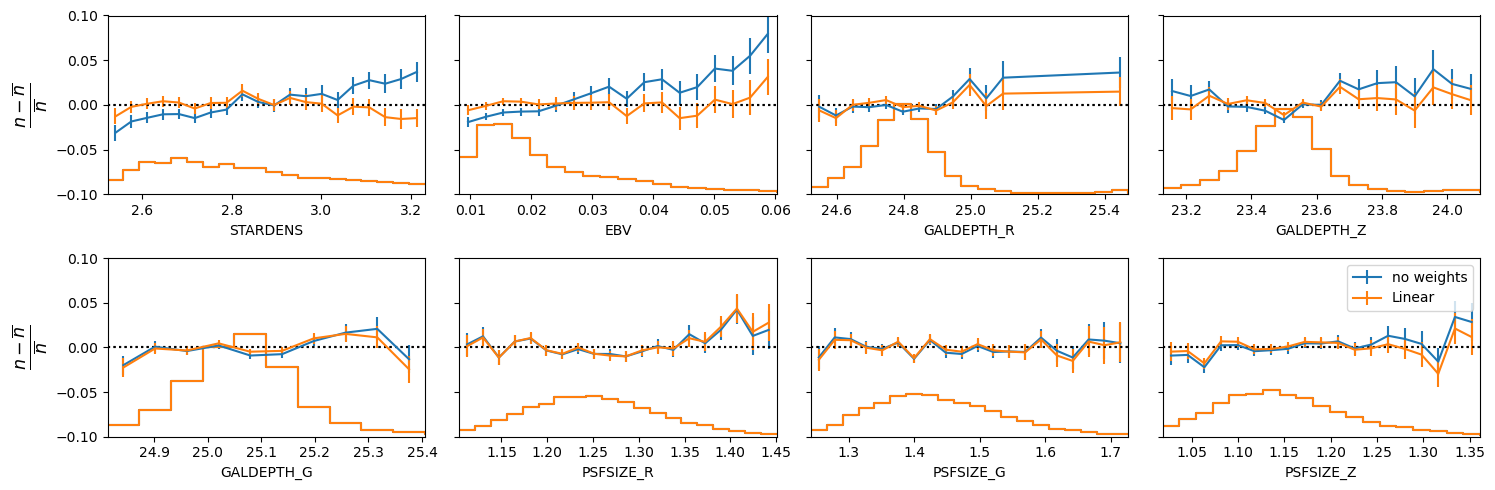

In [60]:

def get_features(tracer):
    if tracer=='LRG':
        feature_names = ['EBV', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
    elif tracer == 'BG':
        feature_names = ['STARDENS', 'EBV', 'GALDEPTH_R', 'GALDEPTH_Z', 'GALDEPTH_G', 'PSFSIZE_R', 'PSFSIZE_G', 'PSFSIZE_Z']
    else:
        raise(f'{tracer} not known only LRG or BG')
    return feature_names


#mask_t = mask_pos(pix,columns)


cols = ['EBV','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','STARDENS']
#mask_t = mask_pos(pix,columns)
mask_t = w!=0
savename = 'test_hist'
plt_hpsyst([target_4m_lrg, target_4m_lrg], features_pixmap, weights=[np.ones_like(w), w], cols=get_features(tracer), do_mask = True, mask=mask_t, savename=savename, labels=['no weights','Linear'])

In [16]:
targets

array([400.33664251, 181.10467161, 328.84795634, ..., 166.80693438,
       200.16832125, 162.04102197])

In [58]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import glob
import fitsio
from astropy.io import fits
import sys

def get_ra_dec(filename):
    data = fitsio.FITS(filename)
    ra = data[1]['RA'].read()
    dec = data[1]['DEC'].read()

    return ra, dec
    
def get_dens(ra,dec,nside, nest=True):
    hp_indices = hp.ang2pix(nside, (90-dec)*np.pi/180, ra*np.pi/180, nest=nest)
    hp_ind_unique, hp_ind_count = np.unique(hp_indices, return_counts=True)
    pixarea = hp.nside2pixarea(nside, degrees=True)
    nb_pix_filled = len(hp_ind_unique)
    nb_pix_tot = hp.nside2npix(nside)
    hp_density = np.zeros(nb_pix_tot)
    hp_density[hp_ind_unique] = hp_ind_count/pixarea

    return hp_density
    
def mask_pos(filename,cols):
	hdul = fits.open(filename)
	data = hdul[1].data
	hdul.close()
	mask = data.field(cols[0])>0.
	for i in range(1,len(cols)):
		mask &= (data.field(cols[i]) > 0.)
	return mask
	
def get_mask(pixfile,col):
	hdul = fits.open(pixfile)
	data = hdul[1].data
	hdul.close()
	mask = data.field(col)
	if 'FRACAREA' in col:
		mask = mask > 0.
	return mask

def plt_hpsyst(filenames_data, filename_pixweight='pixweight-dr10-128-new.fits', cols=[], nside=128, do_mask=False, mask=[], nbins=20, nbmin_hp_perbins=100, nb_rows=2, figsize=(15,5), 
			   ylim=[-0.1,0.1], stardens=0, savename=None, color = ['tab:blue', 'tab:orange'], nest=True, labels=[], weights=None):
    if not isinstance(filenames_data,list):
        filenames_data=[filenames_data]

    if isinstance(filename_pixweight,str):
        hdul = fits.open(filename_pixweight)
        cat_hp = hdul[1].data
        hdul.close()
    else:
        cat_hp = filename_pixweight 

    if len(labels)==0:
        labels = [None]*len(filenames_data)
    if weights is None:
         weights = [np.ones(hp.nside2npix(nside))]*len(filenames_data)
    elif not isinstance(weights, list):
         weights = [weights]
        
    for (kk,filename_data),c,label, weight in zip(enumerate(filenames_data),color,labels, weights):
        
        if isinstance(filename_data,str):
            ra,dec = get_ra_dec(filename_data)
        else:
            ra, dec = filename_data['RA'], filename_data['DEC']
        dens = get_dens(ra,dec,nside,nest) * weight
        if do_mask:
            dens = dens[mask]
        
        nb_plot = len(cols)
        nb_cols = (nb_plot+(nb_rows-1))//nb_rows
        if kk == 0: 
            fig,axes = plt.subplots(nb_rows,nb_cols,figsize=figsize, sharey=True)
            axes=axes.flatten()
    #		c = ['tab:blue', 'tab:orange']

        keep_tot = dens != 0.0
        mean_density = np.mean(dens[keep_tot])

        for i,ax in enumerate(axes):
            #ax = fig.add_subplot(nb_rows, nb_cols, i+1)
            col_name = cols[i]
            data_name = cat_hp[col_name]
            if do_mask:
                data_name = data_name[mask]
            
            minmax = np.quantile(data_name,q=[0.02,0.98])
            min_data = minmax[0]
            max_data = minmax[1]
            
            if 'GALDEPTH' in col_name: 
                data_name = -2.5*(np.log10(5/np.sqrt(data_name))-9)
                min_data = -2.5*(np.log10(5/np.sqrt(min_data))-9)
                max_data = -2.5*(np.log10(5/np.sqrt(max_data))-9)
            if 'STARDENS' in col_name:
                data_name = np.log10(data_name)
                min_data = np.log10(min_data)
                max_data = np.log10(max_data)
            
            sizebin = (max_data - min_data)/(nbins)
            keep_sum = np.zeros(nbins)
            center_bins = np.zeros(nbins)
            nx = np.zeros(nbins)
            nx_std = np.zeros(nbins)
            
            for j in range(nbins):
            
                keep = np.all([keep_tot,data_name>=min_data+sizebin*j, data_name<=min_data+sizebin*(j+1)], axis=0)
                print(col_name, '::  Nb hp for the x-bin (', min_data+sizebin*j, '<x<', min_data+sizebin*(j+1),'): ', np.sum(keep), ' ( nb hp min=', nbmin_hp_perbins, ') ')
                keep_sum[j] = np.sum(keep)
                nx[j] = np.mean(dens[keep]/mean_density)
                nx_std[j] = np.std(dens[keep]/mean_density)
                center_bins[j] = min_data+sizebin*(j+0.5)
            
            ax.set_xlabel(col_name)
            
            keep_plt = keep_sum >= nbmin_hp_perbins
            ax.errorbar(center_bins[keep_plt], nx[keep_plt] - 1, yerr=nx_std[keep_plt]/np.sqrt(keep_sum[keep_plt]), label=label, color=c)
            ax.axhline(0,ls=':',c='k')
            
            hist_count, bin_edges = np.histogram(data_name[keep_tot], bins=nbins, range=(min_data, max_data), weights=np.ones(np.sum(keep_tot))/np.sum(keep_tot)*0.5, density=False)
            x_hist, y_hist = np.ones(2*nbins), np.ones(2*nbins)
            x_hist[::2], x_hist[1::2] = bin_edges[:-1], bin_edges[1:]
            y_hist[::2], y_hist[1::2] = hist_count, hist_count
            shift = ylim[0]
            ax.plot(x_hist, y_hist+shift, color=c)
            ax.fill_between(x_hist, y_hist+shift, y2=shift, alpha=0., color=c)
            ax.set_xlim([center_bins[keep_plt][0]-0.5*sizebin, center_bins[keep_plt][-1]+0.5*sizebin])
            ax.set_ylim(ylim)
    axes[0].set_ylabel(r"$\frac{n - \overline{n}}{\overline{n}}$",fontsize=18) 
    axes[4].set_ylabel(r"$\frac{n - \overline{n}}{\overline{n}}$",fontsize=18) 
    if label is not None:
        ax.legend()
    fig.tight_layout()
    if savename is not None:
        plt.savefig(savename)
    #plt.close()

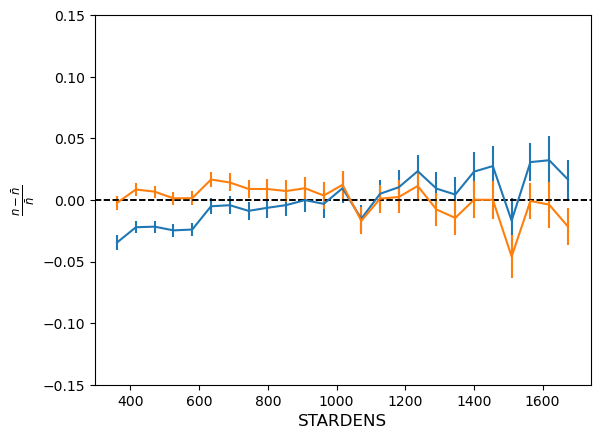

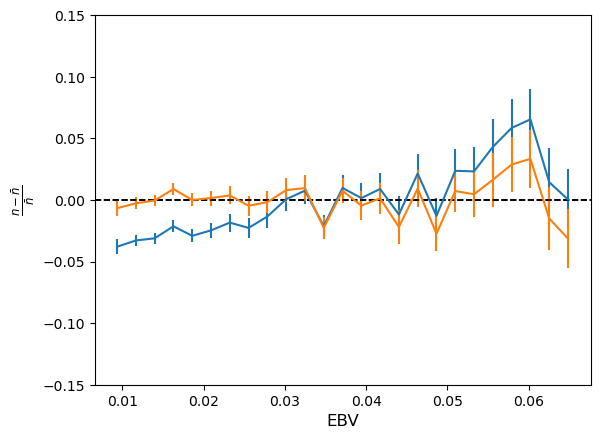

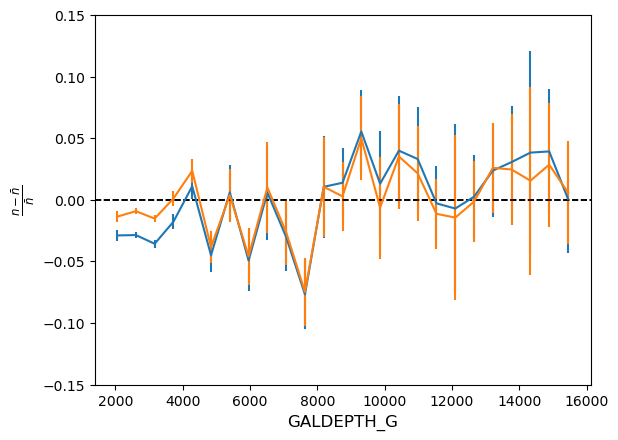

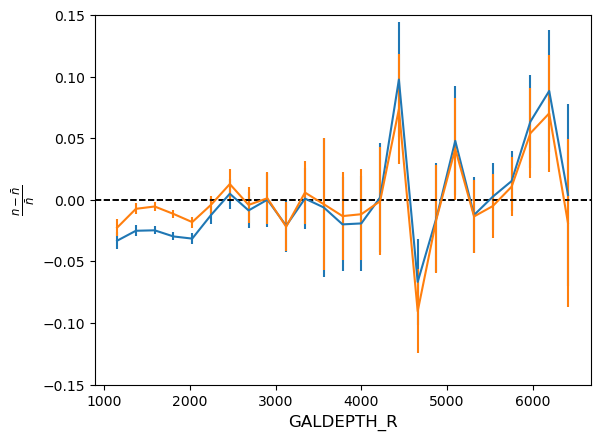

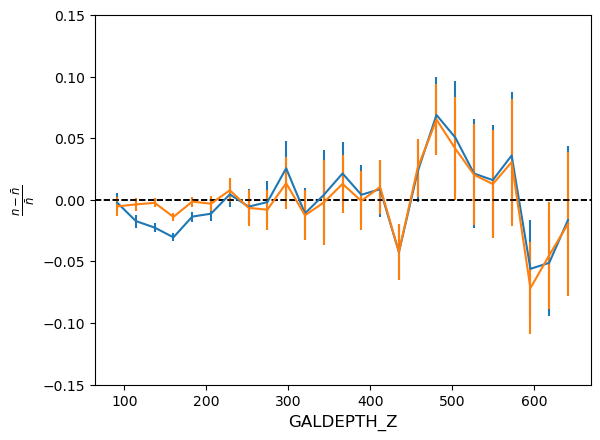

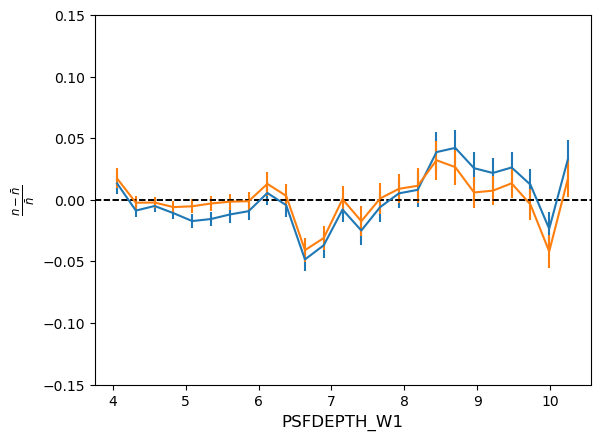

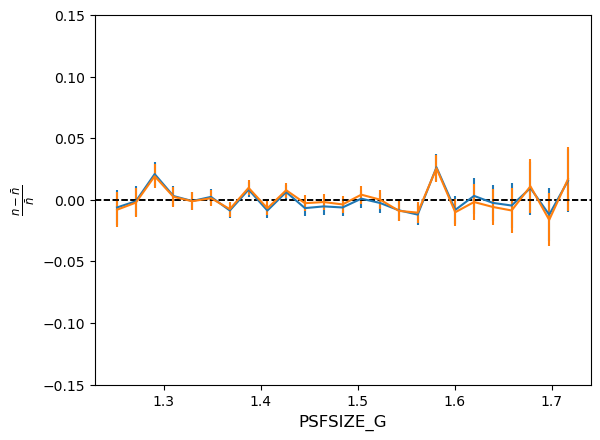

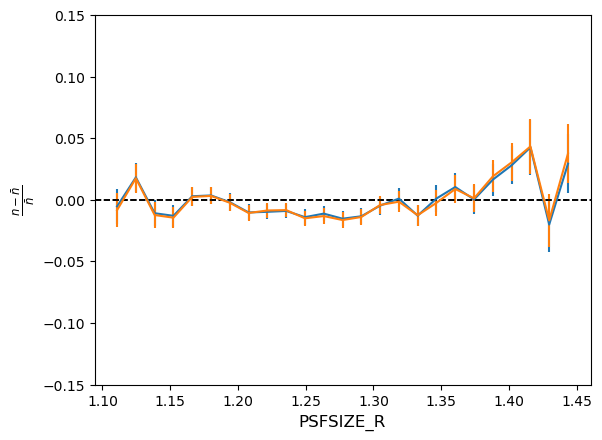

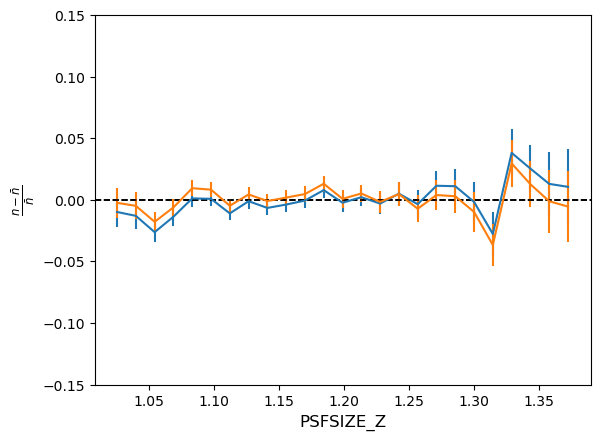

'keep_all = [np.all([keep_tot, weights*hpmap2/hpmap>=bins[i], weights*hpmap2/hpmap<bins[i+1]], axis=0) for i in range(nbins)]\nmean, std = np.array([np.mean((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1]) for mm in keep_all]), [np.std((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1])/np.sqrt(mm.sum()) for mm in keep_all]\n\nplt.errorbar(cbin, mean -1, [np.std(hpmap[mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])'

In [61]:
feature_names = ['STARDENS', 'EBV', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
for feature in feature_names:
    for tar in [targets, targets*w]:
        nbins=25
        #keep_tot = hpmap != 0.0
        keep_tot = w!=0 
        #n_bar = np.mean(hpmap[keep_tot])
        n_bar =np.mean(tar[keep_tot])

        boundary = np.quantile(features_pixmap[feature][keep_tot], q=[0.02,0.98])
        counts, bins = np.histogram(features_pixmap[feature][keep_tot], bins=nbins, range=boundary)
        sizebin= np.diff(bins)[0]
        cbin = 0.5*(bins[1:]+bins[:-1])
        keep_all = [np.all([features_pixmap[feature][keep_tot]>=bins[i], features_pixmap[feature][keep_tot]<bins[i+1]], axis=0) for i in range(nbins)]
        mean, std = np.array([np.mean((tar[keep_tot][mm]/n_bar)[tar[keep_tot][mm]/n_bar>0.1]) for mm in keep_all]), [np.std(tar[keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all]

        #plt.errorbar(cbin, mean -1, [np.std(features_pixmap[feature_names][keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])
        plt.errorbar(cbin, mean/mean.mean() -1, np.hstack(std))

        plt.axhline(0, ls='--', lw=1.2, c='k')
        plt.grid()
        plt.xlabel(feature, fontsize=12)
        plt.ylabel(r'$\frac{n-\bar n}{\bar n}$', fontsize=12)
        plt.ylim(-0.15,0.15)
    plt.show()

'''wtargets = targets * w
n_bar =np.mean(wtargets[keep_tot])

keep_all = [np.all([features_pixmap[feature][keep_tot]>=bins[i], features_pixmap[feature][keep_tot]<bins[i+1]], axis=0) for i in range(nbins)]
mean, std = np.array([np.mean((wtargets[keep_tot][mm]/n_bar)[wtargets[keep_tot][mm]/n_bar>0.1]) for mm in keep_all]), [np.std(wtargets[keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all]

#plt.errorbar(cbin, mean -1, [np.std(features_pixmap[feature_names][keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])
plt.errorbar(cbin, mean/mean.mean() -1, np.hstack(std))
'''


'''keep_all = [np.all([keep_tot, weights*hpmap2/hpmap>=bins[i], weights*hpmap2/hpmap<bins[i+1]], axis=0) for i in range(nbins)]
mean, std = np.array([np.mean((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1]) for mm in keep_all]), [np.std((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1])/np.sqrt(mm.sum()) for mm in keep_all]

plt.errorbar(cbin, mean -1, [np.std(hpmap[mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])'''
